# Introduction to `rasterio` and `atlite`

In this tutorial, we're going to cover two new Python packages:

**Rasterio: access to geospatial raster data**

> Geographic information systems use GeoTIFF and other formats to organize and store gridded raster datasets such as satellite imagery and terrain models. Rasterio reads and writes these formats and provides a Python API based on Numpy N-dimensional arrays and GeoJSON.

:::{note}
Documentation for rasterio is available at https://rasterio.readthedocs.io/en/latest/index.html.
:::

**Atlite: Convert weather data to energy systems data**

> Atlite is a free software, xarray-based Python library for converting weather data (such as wind speeds, solar radiation, temperature and runoff) into power systems data (such as wind power, solar power, hydro power and heating demand time series).

:::{note}
Documentation for atlite is available at https://atlite.readthedocs.io/en/latest/.

This tool is developed here at TU Berlin in the group of Digital Transformation of Energy Systems.
:::

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install atlite rasterio geopandas cartopy matplotlib numpy xarray
```
:::



## Download of Required Data

Before we can run this tutorial, we have to download a few input data files to your local filesystem. The cell below uses some Python utility packages to automate the retrieval of the required files.

In [15]:
from urllib.request import urlretrieve
from os.path import basename

url = (
    "https://tubcloud.tu-berlin.de/s/2oogpgBfM5n4ssZ/download/PORTUGAL-2013-01-era5.nc"
)
urlretrieve(url, basename(url))

('PORTUGAL-2013-01-era5.nc', <http.client.HTTPMessage at 0x1a248865b80>)

## Repetition of Vector Data

In the last tutorial, we used `geopandas` to work with **vector data** (e.g. points, lines, polygons):

Importing the package:

In [16]:
import geopandas as gpd

Reading the file:

In [17]:
url = "https://tubcloud.tu-berlin.de/s/7bpHrAkjMT3ADSr/download/country_shapes.geojson"

In [18]:
countries = gpd.read_file(url).set_index("name")

Inspecting the GeoDataFrame:

In [19]:
countries.tail()

,geometry
name,
VN,"MULTIPOLYGON (((107.49807 14.74595, 107.50928 ..."
YE,"MULTIPOLYGON (((52.09954 18.72304, 52.14233 18..."
ZA,"MULTIPOLYGON (((19.99292 -24.77585, 20.01049 -..."
ZM,"POLYGON ((32.92086 -9.4079, 32.92303 -9.46629,..."
ZW,"POLYGON ((25.25978 -17.79411, 25.26671 -17.800..."


:::{note}
This dataset uses ISO-2 country codes as index: https://en.wikipedia.org/wiki/ISO_3166-1_alpha-2.
:::

Plotting the GeoDataFrame:

<Axes: >

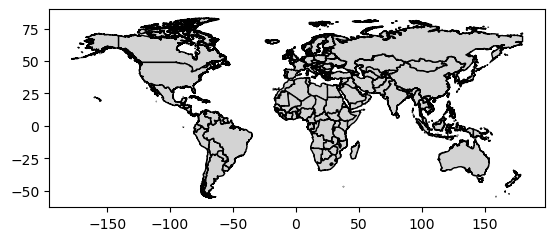

In [20]:
countries.plot(edgecolor="k", facecolor="lightgrey")

Reprojecting geometries in the GeoDataFrame:

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

<GeoAxes: >

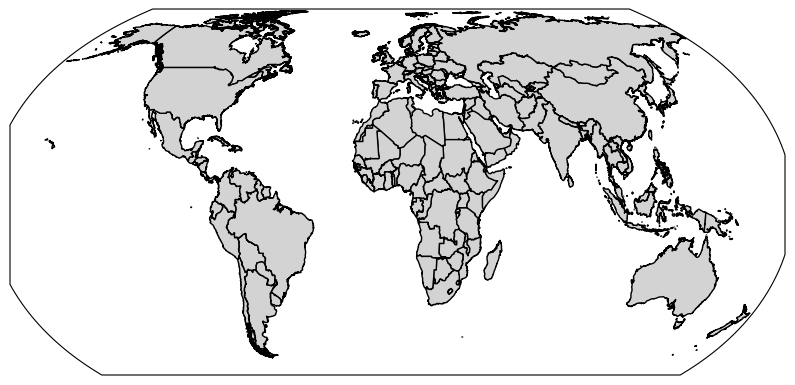

In [22]:
crs = ccrs.EqualEarth()

fig = plt.figure(figsize=(10, 5))

ax = plt.axes(projection=crs)

countries.to_crs(crs.proj4_init).plot(ax=ax, edgecolor="k", facecolor="lightgrey")

## Raster Data with `rasterio`

But we haven't worked with **raster data** yet!

One useful package for working with raster data is [`rasterio`](https://rasterio.readthedocs.io/en/latest/):

In [23]:
import rasterio

With `rasterio`, we can for instance load GeoTIFF files.

In the example below, we load the [CORINE land cover classification](https://land.copernicus.eu/pan-european/corine-land-cover) for Portugal:



In [24]:
url = "https://tubcloud.tu-berlin.de/s/Mw5dwbwdsDY8zfH/download/U2018_CLC2018_V2020_20u1-PT.tif"
clc = rasterio.open(url)

Datasets can have one or more bands (or layers), which can be read with the `.read()` function:

In [25]:
band = clc.read(1)

The returned object is a 2-dimensional `numpy.ndarray`. 

In [26]:
type(band)

numpy.ndarray

In [27]:
band.shape

(5662, 3404)

The band values correspond to a land cover and land use classification scheme with class values as listed [here](https://collections.sentinel-hub.com/corine-land-cover/readme.html).

This is an example of **categorical values** in raster data.

In [28]:
import numpy as np

In [29]:
np.unique(band)

array([-128,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   35,   37,   38,   39,   40,   41,   42,   43,   44],
      dtype=int8)

There are two common options to plot raster data:
- with `plt.imshow()`
- with `rasterio.plot.show()`

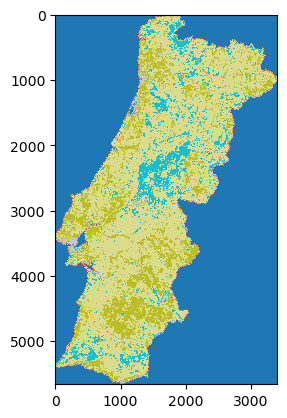

In [30]:
plt.imshow(band, cmap="tab20")

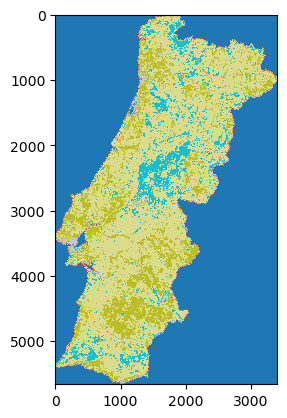

<Axes: >

In [31]:
from rasterio.plot import show

show(band, cmap="tab20")

The integrated `rasterio` plotting functionality is slightly more powerful.

For instance, it can label the axes with proper geo-referenced extents.

These are stored in the `.crs`, `.bounds` and `.transform` attributes.

In [32]:
clc.crs

CRS.from_epsg(3035)

In [33]:
clc.bounds

BoundingBox(left=2635400.0, bottom=1732500.0, right=2975800.0, top=2298700.0)

In [34]:
clc.transform

Affine(100.0, 0.0, 2635400.0,
       0.0, -100.0, 2298700.0)

We can pass the information on the projection to the `rasterio.plot.show()` function:

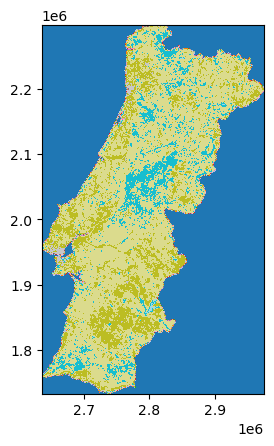

<Axes: >

In [35]:
from rasterio.plot import show

show(band, transform=clc.transform, cmap="tab20")

Let's quickly load another dataset with **continuous values**: The elevation and water depth in and around Portugal.

This dataset comes from [GEBCO Gridded Bathymetry Data](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) and has another file format `.nc` (netCDF) which also stores raster data.

It would be useful to exclude very mountainous areas, or identify shallow water at sea for the development of offshore wind turbines.

In [44]:
url = "https://tubcloud.tu-berlin.de/s/XoDpBcweJHmYKgF/download/GEBCO_2014_2D-PT.nc"
gebco = rasterio.open(url, driver="netcdf")

RasterioIOError: Opening a /vsi file with the netCDF driver requires Linux userfaultfd to be available. Or you may set the GDAL_SKIP=netCDF configuration option to force the use of the HDF5 driver.

In [39]:
band = gebco.read(1)

In [40]:
np.unique(band)

array([-2898, -2862, -2856, ...,  1915,  1926,  1959], dtype=int16)

For plotting, we can also display **vector and raster data together**:

<Axes: >

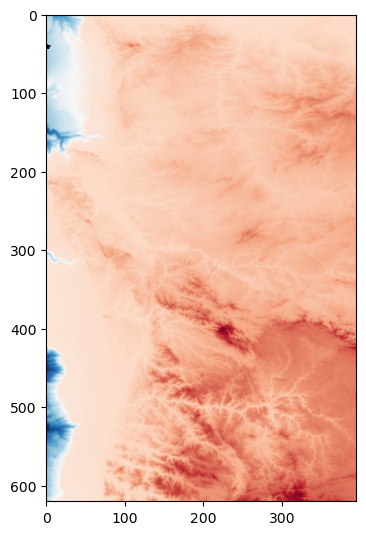

In [43]:
fig, ax = plt.subplots(figsize=(4, 8))

countries.loc[["PT", "ES"]].plot(ax=ax, color="none")

show(band, transform=gebco.transform, cmap="RdBu_r", ax=ax)

## Land Eligibility Analysis with `atlite`

To estimate the wind and solar generation potential of a country, land usage constraints need to be taken into account.

Data required to determine the eligible areas is stored as **raster** and **vector** data.

**Examples:**

- **Vector Data:** natural protection areas, settlements, roads, airports
- **Raster Data:** type of land, elevation, slope

The [`atlite`](https://atlite.readthedocs.io) library has some useful features to handle exclusion constraints for both datatypes.

The core object to do land elibility analysis in `atlite` is the `ExclusionContainer`, which serves as a container for all rasters and geometries we want to exclude (or include).

In [26]:
from atlite.gis import ExclusionContainer

In many cases, rasters and geometries have different projections and resolutions. Therefore, the `ExclusionContainer` is initialized by a CRS and a resolution which suits as a basis for all added rasters and geometries. Per default the CRS is [3035](https://epsg.io/3035) and the resoultion 100, which leads set a raster of 100 meter resolution. All rasters and geometries will be converted to this CRS and resolution.

:::{warning}
The [CRS 3035](https://epsg.io/3035) is only valid in Europe.
:::

In [27]:
excluder = ExclusionContainer(crs=3035)

Let's add our first exclusion criteria, the [Natura2000 natural protection areas](https://www.google.com/search?channel=fs&client=ubuntu&q=natura200), to the container using the `excluder.add_geometry()` function. This function is for vector data. It's sibling, `excluder.add_raster()` we will use later.

In [28]:
url = "https://tubcloud.tu-berlin.de/s/mxgaA7wH8NsmdDi/download/Natura2000_end2021-PT.gpkg"
excluder.add_geometry(url)

To calculate the *mask* for the exclusion container (i.e. which cells are not excluded), we can use the `shape_availability()` function, which takes as arguments:
- a **geometry** (e.g. country shape) within which to calculate available areas
- an **exclusion container** object

In [29]:
from atlite.gis import shape_availability

Since the excluder is in `crs=3035`, we should also convert to geometry of Portucal to `excluder.crs` first.

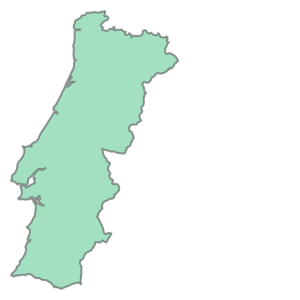

In [30]:
shape = countries.to_crs(excluder.crs).loc[["PT"]].geometry
shape.iloc[0]

We can then call the `shape_availability` function:

In [31]:
band, transform = shape_availability(shape, excluder)

/home/fneum/miniconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_f8aaf795058b4c6a8a51da2370e9666e has GPKG application_id, but non conformant file extension
  return ogr_read(


This function returns a 2-D `numpy.ndarray` and a transformation, similar to the previous `rasterio` examples.

Eligile raster cells have a `True` and excluded cells a `False`.

In [32]:
band

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [33]:
band.any()

True

In [34]:
transform

Affine(100.0, 0.0, 2635400.0,
       0.0, -100.0, 2298700.0)

We can use the `rasterio.plot.show()` function for plotting:

<Axes: >

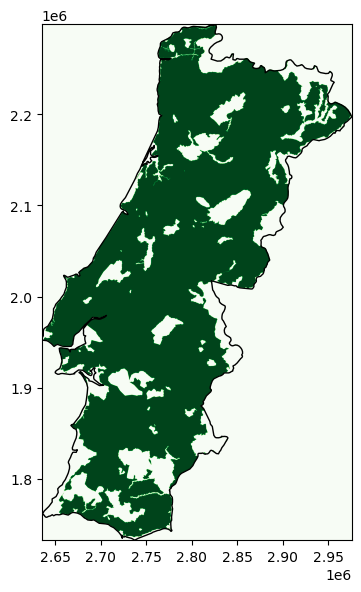

In [35]:
fig, ax = plt.subplots(figsize=(4, 8))
shape.plot(ax=ax, color="none")
show(band, transform=transform, cmap="Greens", ax=ax)

How to calculate what share of the land is eligible?
1. count number of eligible raster cells
2. determine area per raster cell
3. multiply cell area with number of cells
4. divide eligible area by total land area

In [36]:
eligible_cells = band.sum()

In [37]:
cell_area = excluder.res**2

In [38]:
eligible_area = cell_area * eligible_cells

In [39]:
country_area = shape.geometry.area.iloc[0]

In [40]:
eligible_area / country_area * 100

79.65002907506357

In this example, approximately 20% of Portugal's land area are covered by nature reserves.

Typically, more than one dataset is needed for a proper land eligibility analysis, i.e. we need to add more datasets to our container.
So, let's expand the exclusion container ...

In [41]:
url = "https://tubcloud.tu-berlin.de/s/mxgaA7wH8NsmdDi/download/Natura2000_end2021-PT.gpkg"
excluder = ExclusionContainer()
excluder.add_geometry(url)

... by a selection of CORINE land cover classes, which is given as raster data:

When adding a raster to the `ExclusionContainer` you can specify which **codes** (integers) to exclude.

By setting `invert=True`, you can also restrict the inclusion to a set of codes.

Furthermore, you can add a **buffer** around codes which should also be excluded.

Here we are first going to include a set of suitable [CORINE classes](https://collections.sentinel-hub.com/corine-land-cover/readme.html):

In [42]:
fn = "https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/U2018_CLC2018_V2020_20u1-PT.tif"

In [43]:
codes = [12, 13, 18, 19, 20, 21]

In [44]:
excluder.add_raster(fn, codes=codes, crs=3035, invert=True)

And then we are going exclude [CORINE classes](https://collections.sentinel-hub.com/corine-land-cover/readme.html) representing settled areas with an 800 meter buffer around them:

In [45]:
codes = [1, 2, 3, 4, 5, 6]

In [46]:
excluder.add_raster(fn, codes=codes, buffer=800, crs=3035)

Then, we can simply repeat the calculation and visualisation of available cells:

/home/fneum/miniconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: File /vsimem/pyogrio_6320e50ef7644898b18c9938b56545c8 has GPKG application_id, but non conformant file extension
  return ogr_read(


<Axes: >

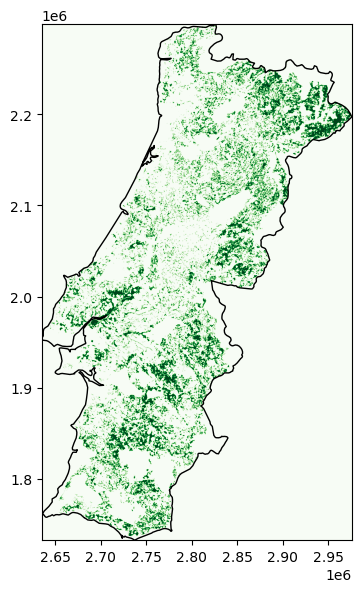

In [47]:
band, transform = shape_availability(shape, excluder)

fig, ax = plt.subplots(figsize=(4, 8))
shape.plot(ax=ax, color="none")
show(band, transform=transform, cmap="Greens", ax=ax)

## Spatial and Temporal Availability

Besides calculating spatial potential for renewables development, [`atlite`](https://atlite.readthedocs.io) can also handle weather data time series and convert them to energy systems time series (like production time series for wind and solar).

One famous such dataset is the [ERA5 reanalysis data](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) which has historical weather data for the whole world from 1959 to 2022 at hourly resolution and on a 0.25 x 0.25 degree grid (roughly 25-30 km depending on where you are).

`atlite` can be imported like this (usually without an alias):

In [48]:
import atlite

A cutout is the basis for any of your work and calculations and contains all the weather data.

Here, we load an existing dataset which was retrieved from `ERA5`.

In [49]:
cutout = atlite.Cutout("PORTUGAL-2013-01-era5.nc")

In [50]:
cutout

<Cutout "PORTUGAL-2013-01-era5">
 x = -9.90 ⟷ -6.00, dx = 0.30
 y = 36.00 ⟷ 42.90, dy = 0.30
 time = 2013-01-01 ⟷ 2013-02-01, dt = h
 module = era5
 prepared_features = ['height', 'wind', 'influx', 'temperature', 'runoff']

In [51]:
cutout.data

<xarray.Dataset> Size: 17MB
Dimensions:           (x: 14, y: 24, time: 768)
Coordinates:
  * x                 (x) float64 112B -9.9 -9.6 -9.3 -9.0 ... -6.6 -6.3 -6.0
  * y                 (y) float64 192B 36.0 36.3 36.6 36.9 ... 42.3 42.6 42.9
  * time              (time) datetime64[ns] 6kB 2013-01-01 ... 2013-02-01T23:...
    lon               (x) float64 112B dask.array<chunksize=(14,), meta=np.ndarray>
    lat               (y) float64 192B dask.array<chunksize=(24,), meta=np.ndarray>
Data variables: (12/13)
    height            (y, x) float32 1kB dask.array<chunksize=(24, 14), meta=np.ndarray>
    wnd100m           (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    wnd_azimuth       (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    roughness         (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    influx_toa        (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    influx_direct     (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    ...                ...
    albedo            (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    solar_altitude    (time, y, x) float64 2MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    solar_azimuth     (time, y, x) float64 2MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    temperature       (time, y, x) float64 2MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    soil temperature  (time, y, x) float64 2MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
    runoff            (time, y, x) float32 1MB dask.array<chunksize=(100, 24, 14), meta=np.ndarray>
Attributes:
    module:             era5
    prepared_features:  ['height', 'runoff', 'temperature', 'wind', 'influx']
    chunksize_time:     100
    dx:                 0.3
    dy:                 0.3
    Conventions:        CF-1.6
    history:            2022-03-04 14:08:37 GMT by grib_to_netcdf-2.24.2: /op...

Let's quickly plot the spatial resolution and scope of this dataset:

<Axes: >

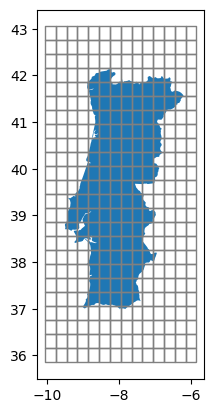

In [52]:
ax = shape.to_crs(4326).plot()
cutout.grid.plot(ax=ax, edgecolor="grey", color="None")

We can directly access, aggregate, and plot individual meteorological parameters:

In [53]:
wnd100m = cutout.data.wnd100m.mean(dim="time")

<GeoAxes: xlabel='x', ylabel='y'>

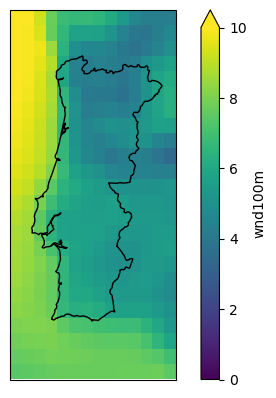

In [54]:
ax = plt.axes(projection=ccrs.PlateCarree())

wnd100m.plot(ax=ax, vmin=0, vmax=10)

shape.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")

This cutout happens to also have data on the surface roughness. We can use this to scale the 100 meter wind speeds down to 10 meters using the **log law**:

$$\frac{U(z)}{U(z_r)} = \frac{\ln\left(\frac{z}{z_0}\right)}{\ln\left(\frac{z_r}{z_0}\right)}$$

In [55]:
z_r = cutout.data.roughness
wnd100m = cutout.data.wnd100m

In [56]:
wnd10m = wnd100m * np.log(10 / z_r) / np.log(100 / z_r)

<GeoAxes: xlabel='x', ylabel='y'>

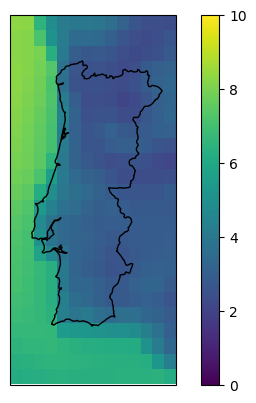

In [57]:
ax = plt.axes(projection=ccrs.PlateCarree())

wnd10m.mean(dim="time").plot(ax=ax, vmin=0, vmax=10)

shape.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")

We can also build means in the spatial dimensions and investigate the behaviour of meteorological variables over time. Here, we do this for the direct solar irradiation.

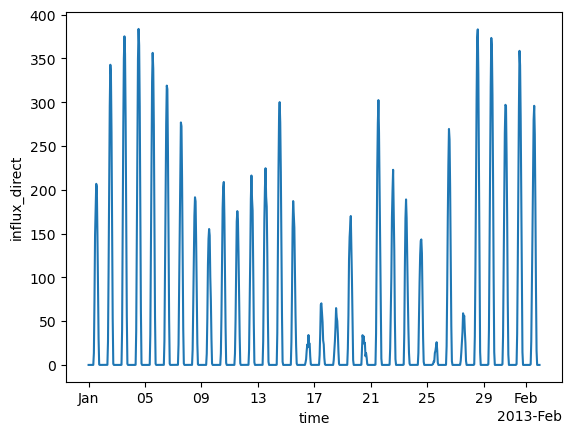

In [58]:
cutout.data.mean(dim=["x", "y"]).influx_direct.plot()

We also already saw that the weather cells are much larger than the raster cells. `atlite` automates this conversion for averaging fine-grained to coarse-grained rasters for all geometries in shapes when calling the `cutout.availabilitymatrix()` function. 

In [59]:
A = cutout.availabilitymatrix(shape, excluder)

`A` is an array with 3 dimensions (`shape`, `x`, `y`) and very sparse data. It indicates the relative overlap of weather cell (`x`, `y`) with geometry shape while excluding the area specified by the excluder.

<Axes: title={'center': 'name = PT'}, xlabel='x', ylabel='y'>

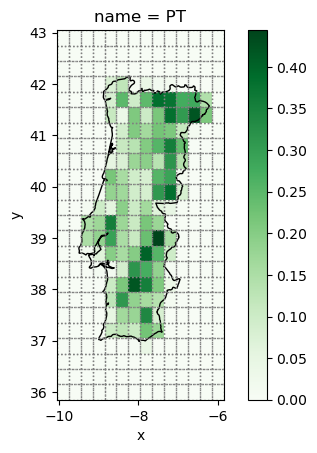

In [60]:
fig, ax = plt.subplots()
A.sel(name="PT").plot(cmap="Greens")
shape.to_crs(4326).plot(ax=ax, edgecolor="k", color="none")
cutout.grid.plot(ax=ax, color="none", edgecolor="grey", ls=":")

The availibility matrix `A` can now be used as a layout matrix in the conversion functions of `atlite` from wind speeds to capacity factors.

The general approach would be to weigh the availabilities with the area per grid cell and the allowed deployment density (capacity per area).

:::{note}
We won't cover `xarray` in detail in this course, but for now you can imagine it as a performant multi-dimensional version of `pandas`.
:::

In [61]:
import xarray as xr

cap_per_sqkm = 2  # 2 MW/km^2
area = cutout.grid.set_index(["y", "x"]).to_crs(3035).area / 1e6  # in km^2
area = xr.DataArray(area, dims=("spatial"))

capacity_matrix = A.stack(spatial=["y", "x"]) * area * cap_per_sqkm

This code block processes the three-dimensional availability matrix `A` (representing a spatial grid with values between 0 and 1 indicating the relative eligible area per square) to calculate the capacity per square kilometer for each grid cell. First, the `cutout.grid` is assigned its latitudes and longitudes as coordinates, before the area of each grid cell is calculated. This new `area` object is converted into an `xarray.DataArray` with a single spatial dimension called "spatial". Finally, the availability matrix `A` is flattened (stacked) into a two-dimensional array along the spatial dimensions, x and y, aligning it with the dimensions of `area`. Each cell's value is multiplied by its corresponding area and a capacity factor (`cap_per_sqkm`).

Using the resulting `capacity_matrix` which contains for each grid cell the maximum deployable capacity, we can now calculate the capacity factor time series for Portugal.

In [63]:
wind = cutout.wind(matrix=capacity_matrix, turbine="Vestas_V90_3MW", index=shape.index)

/home/fneum/miniconda3/envs/esm-ws-24-25/lib/python3.12/site-packages/atlite/resource.py:72: FutureWarning: 'add_cutout_windspeed' for wind turbine
power curves will default to True in atlite relase v0.2.15.
  warnings.warn(msg, FutureWarning)


Let’s see how the total wind power potential looks like:

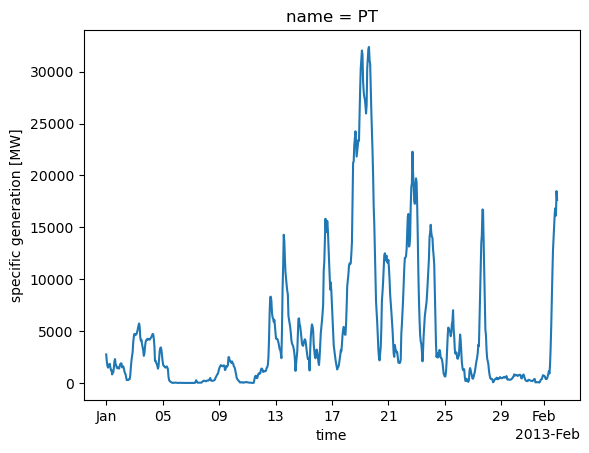

In [64]:
wind.plot()

Analogously, we can also determine the potential power generation time series of solar photovoltaics parks:

:::{note}
For simplicity, we assume the same deployment density and land eligibility criteria as for wind. Note that in reality, different eligibility criteria apply for solar and wind developments.
:::

For that, we have to specify the [type of panel](https://en.wikipedia.org/wiki/Solar_panel#Technology) (CSi refers to a crystalline silicon panel), the orientation (azimuth of 180° means southward orientation, slope refers to inclination angle from the ground).

In [65]:
pv = cutout.pv(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    matrix=capacity_matrix,
    index=shape.index,
)

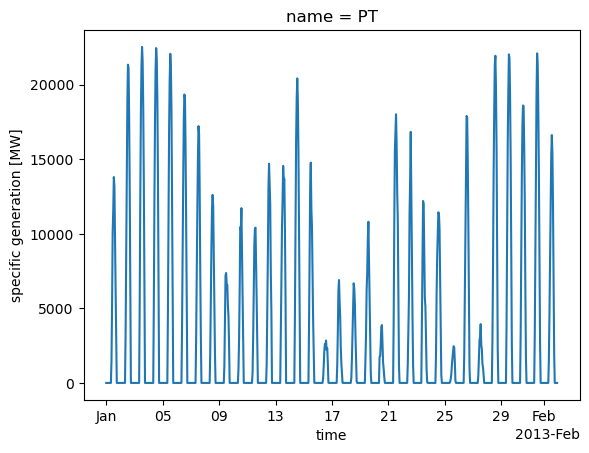

In [66]:
pv.plot()

## Exercises

### Exercise 1

Tweak some parameters of the land exclusion calculation for wind deployment:

- Vary the [CORINE land classes](https://collections.sentinel-hub.com/corine-land-cover/readme.html) allowed for wind turbine development.
- Vary the buffer distance from 0m to 2000m in steps of 250m and observe the change in availble area.
- Add the [GEBCO topography data](https://www.gebco.net/) loaded at the beginning of the tutorial to the exclusion calculator and exclude areas above 1000m elevation.


Solution:

1. Change codes in `excluder.add_raster(fn, codes=codes, crs=3035, invert=True)` 
2. Change buffer in `excluder.add_raster(fn, codes=codes, buffer=800, crs=3035)`
3. Add line `excluder.add_raster(fn_to_gebco, crs=4326)` as data is given in different projection.


### Exercise 2

The orientation of solar panels plays a decisive role in determining their potential power generation time series. Explore this aspect by performing the following sensitivity analysis:

- Plot the total energy yield in January as a function of the slope of the panels oriented towards the South (0° means horizontal orientation, 90° means vertical orientation) in steps of 10°. What is the optimal tilt angle? Why might the value be higher than typically recommended for PV panels?
- Plot the power production profile for January 1 for the azimuth angles 0°, 90°, 180°, 270° of panels tilted at a 30° angle. What orientation does each angle represent? Describe the differences you observe.
- The `cutout.pv()` function can also consider multiple options for tracking features of solar panels as listed below. Tracking in solar panel systems refers to the mechanism that allows panels to move and orient themselves towards the sun, maximizing their exposure to sunlight and thereby increasing their electricity output. The default settings in `atlite` assume no tracking devices. Explore and describe the power output profile for different tracking options for January 31. How much more expensive in percent can the equipment for tracking be to achieve the same cost per unit of electricity produced as a fixed panel (if it only operated in January)?

Available tracking options in `atlite` are:

- `tracking='horizontal'` for 1-axis horizontal tracking: This setting positions solar panels to rotate around a horizontal axis, allowing them to follow the sun's path from east to west.
- `tracking='vertical'` for 1-axis vertical tracking: In this mode, the solar panels rotate around a vertical axis, which can be advantageous in high latitudes for better sun capture throughout the day.
- `tracking='dual'` for 2-axis tracking: This advanced system allows panels to track the sun both horizontally and vertically, maximizing solar exposure and energy capture throughout the day and year.

For all calculations, assume the same deployment density and land eligibility criteria as for wind (for simplicity).

In [ ]:
import pandas as pd

kwargs = dict(
    panel="CSi",
    matrix=capacity_matrix,
    index=shape.index,
)

pv_orientation = {}
for slope in range(0, 100, 10):
    print(f"slope: {slope}°")
    pv_orientation[slope] = (
        cutout.pv(orientation=dict(slope=slope, azimuth=180.0), **kwargs)
        .to_pandas()
        .squeeze()
        .div(1e3)
    )  # GW

df = pd.DataFrame(pv_orientation)

df.sum().plot(ylabel="electricity output [GWh]", xlabel="slope [°]")

best = df.sum().idxmax()
print("The optimal slope is {:.0f}°".format(best))

In [ ]:
kwargs = dict(
    panel="CSi",
    matrix=capacity_matrix,
    index=shape.index,
)

pv_azimuth = {}
for angle in [0, 90, 180, 270]:
    print(f"azimuth: {angle}°")
    pv_azimuth[angle] = (
        cutout.pv(orientation=dict(slope=30, azimuth=angle), **kwargs)
        .to_pandas()
        .squeeze()
        .div(1e3)
    )  # GW

df = pd.DataFrame(pv_azimuth)

df.loc["2013-01-01"].plot(ylabel="power output [GW]")

- 0° is North (minimum output as sun traverses from East to West via South in Northern hemisphere)
- 90° is East (sun reaches panel earlier, departs earlier)
- 270° is West (sun reaches panel later, departs later)
- 180° is South (maximum output)

In [ ]:
kwargs = dict(
    panel="CSi",
    orientation={"slope": 30.0, "azimuth": 180.0},
    matrix=capacity_matrix,
    index=shape.index,
)

pv_h = cutout.pv(tracking="horizontal", **kwargs)

pv_v = cutout.pv(tracking="vertical", **kwargs)

pv_d = cutout.pv(tracking="vertical", **kwargs)

In [ ]:
day = "2013-01-31"
fig, ax = plt.subplots()
pv.loc[day].plot(ax=ax, label="fixed")
pv_v.loc[day].plot(ax=ax, label="vertical")
pv_h.loc[day].plot(ax=ax, label="horizontal")
pv_d.loc[day].plot(ax=ax, label="dual")
plt.legend()